In [37]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
experiments = [
    'exp_1',
    'exp_2_1', 
]

models = [
    'openai--gpt-4o',
    'openai--gpt-4o-mini', 
    # 'llama3_1_instruct--70b',
    'llama3_1--8b',
    'gemma2--9b',
    'qwen2--7b',
    'exaone--8b',
]
results = {
    'experiment': [],
    'model': [],
    'diff': [],
    'modal_expression': []
}


model_rename = {
    'openai--gpt-4o': 'GPT-4o',
    'openai--gpt-4o-mini': 'GPT-4o-mini',
    'llama3_1--8b': 'LLaMA3.1-8B',
    'gemma2--9b': 'Gemma2-9B',
    'exaone--8b': 'ExaOne-8B',
    'qwen2--7b': 'Qwen2-7B',
}


import re 
def get_value(string):
        # 처음 digits 를 뽑아서 저장. regex 사용.
    match = re.search(r'\d+', string)
    if match:
        return int(match.group())
    else:
        return None

for experiment in experiments:
    for model in models:
        csv_path = f"results/{experiment}/General_Regression/{model}.csv"
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            with_values = df[df['input_type'] == 'strong']
            without_values = df[df['input_type'] == 'none']
            differences = [] 
            for i in range(len(with_values)):
                v1 = get_value(str( with_values['model_output_raw'].values[i]))
                v2 = get_value(str(without_values['model_output_raw'].values[i]))
                if v1 is None or v2 is None:
                    continue
                difference = v1 - v2
                differences.append(difference)
    
            for difference in differences:
                results['experiment'].append(experiment)
                results['model'].append(model_rename[model])
                results['diff'].append(difference)
                results['modal_expression'].append('General')

results = pd.DataFrame(results)

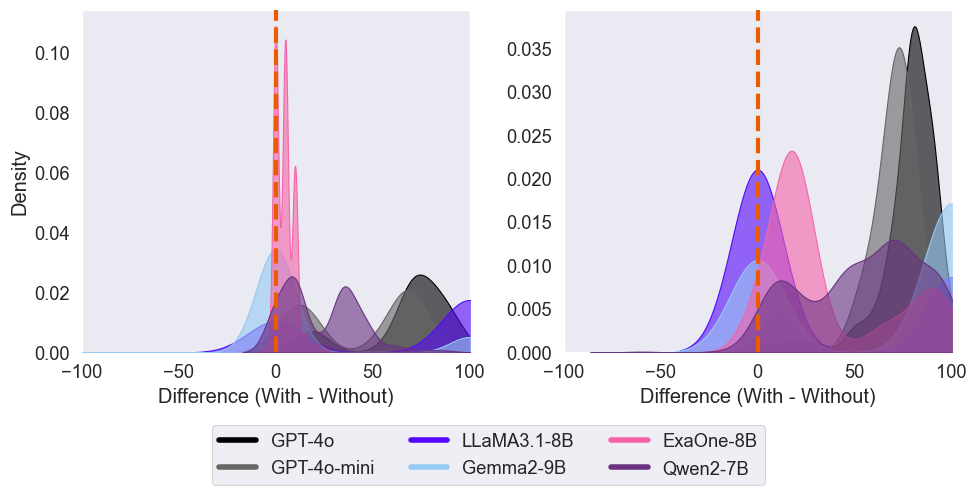

In [50]:
sns.set_theme(style="dark")
sns.set_context("paper", font_scale=1.5)
fig, axes = plt.subplots(1, 2, figsize=(10, 4.4))

palette = ['#000000', '#666666', '#5409FA', '#96C9F4', '#F564A9', '#693382']
hue_order = ['GPT-4o', 'GPT-4o-mini', 'LLaMA3.1-8B', 'Gemma2-9B', 'ExaOne-8B', 'Qwen2-7B']
zorders = [1, 2, 3, 4, 5, 6]  # 각 모델별 zorder 값

for i, experiment in enumerate(experiments):
    v = results[results['experiment'] == experiment]
    # 각 모델별로 데이터를 분리하여 그리기
    for model in hue_order:
        model_data = v[v['model'] == model]
        if not model_data.empty:
            sns.kdeplot(x='diff', data=model_data, ax=axes[i], 
                       color=palette[hue_order.index(model)],
                       fill=True, legend=False,
                       alpha=0.6, zorder=zorders[hue_order.index(model)])
    
    # axes[i].set_title(experiment)
    axes[i].set_xlim(-100, 100)
    axes[i].axvline(0, lw=3, color='#EB5B00', linestyle='--', zorder=10)
    axes[i].set_xlabel("Difference (With - Without)")
    if i==1:
        axes[i].set_ylabel("")


# 공통 범례 생성
lines = []
labels = []
for color, label in zip(palette, hue_order):
    lines.append(plt.Line2D([0], [0], color=color, lw=4))
    labels.append(label)

fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.savefig(f"figure_regression.pdf", dpi=300, bbox_inches='tight')